In [9]:
# Importing Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import os
from google.colab import drive
from glob import glob
import time
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Flatten, Dense
from sklearn.metrics import roc_curve, auc, accuracy_score

In [2]:
# Mount Google Drive and Define Dataset Path
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/Dataset'
image_files = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith(('jpg', 'jpeg', 'png'))]

Mounted at /content/drive


In [3]:
# Create ImageDataGenerator for Data Loading and Augmentation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42
)
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)

Found 18900 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.


In [6]:
# Load Pre-trained VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in base_model.layers:
    layer.trainable = False

folders = glob(r"/content/drive/MyDrive/Dataset/*")
x = Flatten()(base_model.output)
predictions = Dense(len(folders), activation='sigmoid')(x)
model = models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
# Define a callback to print a message and keep the session active
class KeepSessionActiveAndSaveModel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("Colab is active! Epoch:", epoch + 1)
        # Save the model after each epoch
        self.model.save("/content/drive/MyDrive/VGG16_30epoch.h5".format(epoch + 1))

# Train the model using the generators with the callback
model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[KeepSessionActiveAndSaveModel()]
)


Epoch 1/30
591/591 [==============================] - ETA: 0s - loss: 0.3315 - accuracy: 0.8924Colab is active! Epoch: 1


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


591/591 [==============================] - 1460s 2s/step - loss: 0.3315 - accuracy: 0.8924 - val_loss: 0.3875 - val_accuracy: 0.8699
Epoch 2/30
591/591 [==============================] - 1465s 2s/step - loss: 0.3186 - accuracy: 0.8928 - val_loss: 0.3843 - val_accuracy: 0.8683
Epoch 3/30
591/591 [==============================] - 1467s 2s/step - loss: 0.3063 - accuracy: 0.9000 - val_loss: 0.3860 - val_accuracy: 0.8711
Epoch 4/30
591/591 [==============================] - 1465s 2s/step - loss: 0.2967 - accuracy: 0.9029 - val_loss: 0.3677 - val_accuracy: 0.8753
Epoch 5/30
591/591 [==============================] - 1465s 2s/step - loss: 0.2870 - accuracy: 0.9062 - val_loss: 0.3743 - val_accuracy: 0.8702
Epoch 6/30
591/591 [==============================] - 1461s 2s/step - loss: 0.2808 - accuracy: 0.9089 - val_loss: 0.3760 - val_accuracy: 0.8725
Epoch 7/30
591/591 [==============================] - 1464s 2s/step - loss: 0.2729 - accuracy: 0.9108 - val_loss: 0.3695 - val_accuracy: 0.8723
Epo

Found 1000 images belonging to 10 classes.
32/32 [==============================] - 241s 8s/step


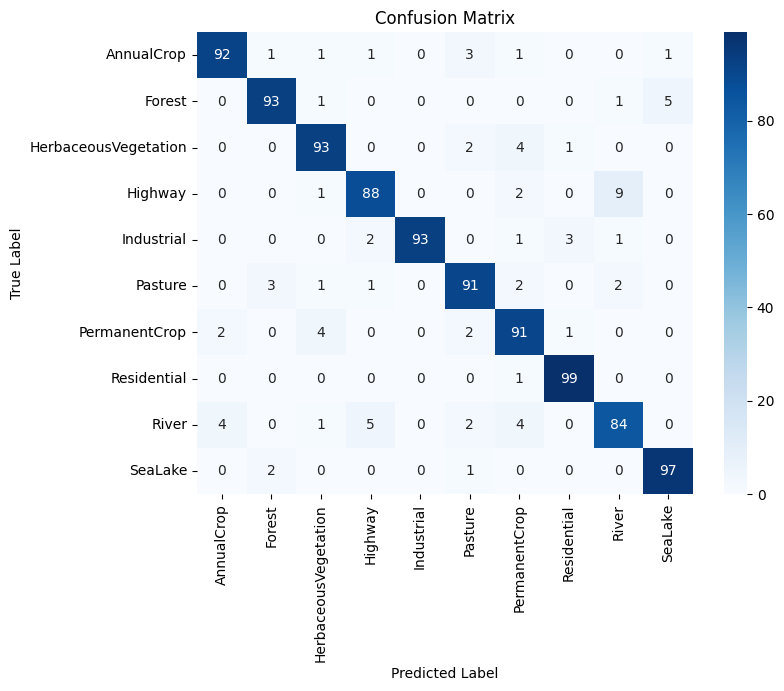

In [7]:
# Evaluate the Model and Generate Confusion Matrix
model = load_model('/content/drive/MyDrive/VGG16_30epoch.h5')
test_data_dir = '/content/drive/MyDrive/Testing Dataset'
input_size = (64, 64)
batch_size = 32
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [12]:
# Compute Classification Report and Accuracy
class_report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)
print("Classification Report:")
print(class_report)
accuracy = accuracy_score(true_labels, predicted_labels) * 100
print("The accuracy of VGG16 Model is: ", accuracy)

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.94      0.92      0.93       100
              Forest       0.94      0.93      0.93       100
HerbaceousVegetation       0.91      0.93      0.92       100
             Highway       0.91      0.88      0.89       100
          Industrial       1.00      0.93      0.96       100
             Pasture       0.90      0.91      0.91       100
       PermanentCrop       0.86      0.91      0.88       100
         Residential       0.95      0.99      0.97       100
               River       0.87      0.84      0.85       100
             SeaLake       0.94      0.97      0.96       100

            accuracy                           0.92      1000
           macro avg       0.92      0.92      0.92      1000
        weighted avg       0.92      0.92      0.92      1000

The accuracy of VGG16 Model is:  92.10000000000001


<ipython-input-13-a4975b65d0fa>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='red', label='Random')


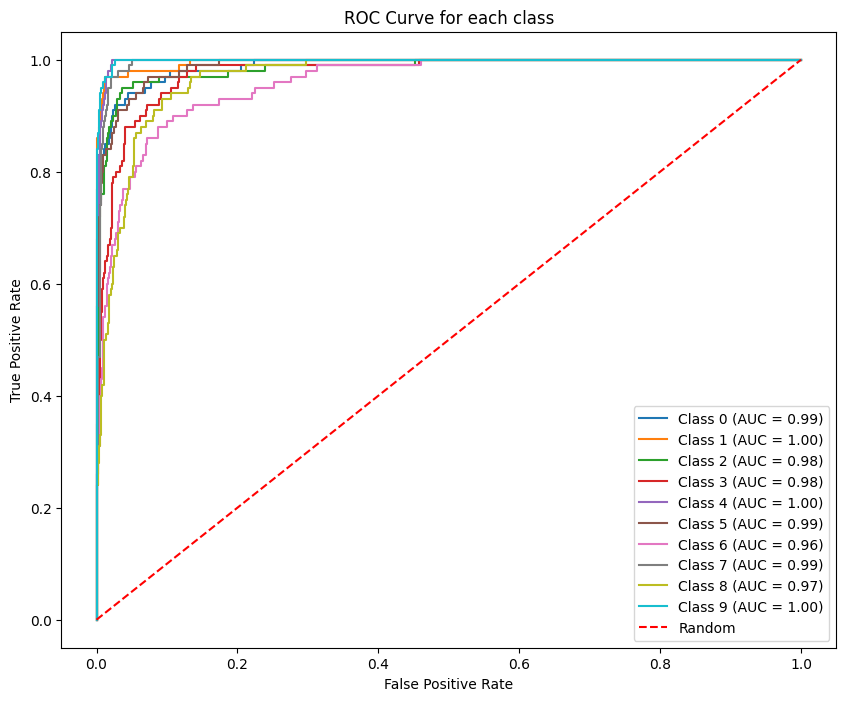

In [13]:
# Compute ROC Curve Each Class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(test_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(test_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', color='red', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc='best')
plt.show()


In [16]:
# Calculate Precision, Recall, True Positive Rate, Falso Positive Rate and Area Under Curve
# Define the number of classes
num_classes = len(test_generator.class_indices)

# Set a common threshold for binary classification
threshold = 0.5

# Convert predicted probabilities to binary predictions
predicted_labels_binary = (predictions > threshold).astype(int)

# Extract True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN)
tp = int((accuracy / 100) * len(true_labels))
fp = len(true_labels) - tp
tn = int((accuracy / 100) * len(true_labels))
fn = len(true_labels) - tn

# Calculate True Positive Rate (TPR), False Positive Rate (FPR), Precision, Recall, F1 Score
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
precision = tp / (tp + fp)
recall = tp
f1 = 2 * (precision * recall) / (precision + recall)

# Calculate Area Under ROC Curve (AUC)
roc_auc = dict()
for i in range(num_classes):
    fpr_i, tpr_i, _ = roc_curve(true_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr_i, tpr_i)

# Display the computed metrics for the  dataset
print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Area Under ROC Curve (AUC): {np.mean(list(roc_auc.values())):.4f}")

True Positive Rate (TPR): 0.9210
False Positive Rate (FPR): 0.0790
Precision: 0.9210
Recall: 921.0000
F1 Score: 1.8402
Area Under ROC Curve (AUC): 0.9854
